# Filtering and analyzing Singapore-based tweets - data ingestion, data wrangling, and exploratory data analysis

### Introduction

**Factual**: Estimated Singapore Twitter Users 1.7M [Source](https://www.statista.com/statistics/490600/twitter-users-singapore/#:~:text=Number%20of%20Twitter%20users%20in%20Singapore%202019%2D2021&text=In%202021%2C%20there%20were%20over,between%2025%2D34%20years%20old)

Less than 1% of the tweets are geotagged with GPS location.

**Challenge**: How to collect tweets by ***Singapore located users*** from streaming twitter data?

https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

### [Table of Contents](#cell2)

* 1\. [Heuristics for filtering Singapore-based users' tweets from streaming twitter API](#cell1)
* 2\.     [Loading the data (csv files)](#cell2)
* 3\. [Cleaning and processing the data](#cell3)
    * 3.1. [Datetime cleanup and formatting](#cell31)
    * 3.2. [Geocoding fixes](#cell32)
<!--         * 3.2.1 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.2 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.3 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.4 [Replacing nan with 'Unknown'](#cell321) -->
    * 3.3. [Filtering out non-Singapore accounts - reducing false positives and false negatives](#cell33)
    * 3.4. [Processing the tweets and quoted tweets](#cell34)
* 4\. [Exploratory data analysis of Singapore geo-coded tweets](#cell4) 
    * 4.1. [Basics](#cell41)
    * 4.2. [Analysing Singapore users](#cell42)
    * 4.3. [Sentiment analysis of tweets and quoted tweets](#cell35)
    * 4.4. [Analysing potentially sensitive tweets (PST) with links](#cell43)
    * 4.5. [Popular hashtags](#cell44)
    * 4.6. [Popular mentions](#cell45)
    * 4.7. [Regional analysis](#cell46)
    * 4.8. [Others](#cell46)

In [253]:
import re
import os
import time
import glob 
import json
import random
from datetime import datetime  as dt

import collections as col

import numpy as np
import pandas as pd

# import functools as ft
import itertools as it

# visualizations
import plotly.express as px
import matplotlib.pyplot as plt

In [96]:
import warnings
warnings.filterwarnings("ignore")

# 1. Heuristics for filtering Singapore-based users' tweets from streaming twitter API 

##### Tweets from the streaming twitter API are first ingested into MongoDB. The below heuristics are then applied on the collected tweets to fetch Singapore-based users' tweets:   

**Step 1 -  Collection of potential Singapore-based twitter users:** Users who follow at least 2 of the Singapore based twitter accounts listed below: 

`Singapore based twitter handles
'mindefsg', 'MOEsg', 'sporeMOH', 'LTAsg', 'SMRT_Singapore', 'SBSTransit_Ltd', 'SingaporeHDB', 'MNDSingapore', 'mhasingapore', 'SingaporePolice', 'URAsg',  'MAS_sg', 'MOFsg', 'ICASingapore', 'SingaporeMCI', 'nlbsingapore', 'IMDAsg',  'NEAsg', 'nparksbuzz', 'SGSportsHub', 'govsingapore', 'SingaporeCAAS', 'MFAsg',
 ‚Äòiremembersg', 'youthsg', 'NUSingapore', 'NTUsg', 'sgSMU', 'sutdsg', 'SGRedCross',  'STcom', 'ChannelNewsAsia', 'TODAYonline', 'asiaonecom', 'thenewpaper', 'MothershipSG', 'Singtel', 'StarHub', 'MyRepublicSG', 'M1Singapore', 'temasekpoly', 'singaporetech','SingaporePoly', 'PUBsingapore', 'NgeeAnnNP', 'ITESpore', 'mediacorp', 'YahooSG',  'TimeOutSG', 'VisitSingapore', 'stb_sg', 'GovTechSG', 'SGmagazine', 'mySingapore',  'sgelection', 'SGAG_SG', 'TEDxSingapore', 'STATravelSG', 'STPix'`
 
##### Collected users count: 888739

The file `/data/min_2_following_users.txt` contains the list of collected twitter user ids.

**Step 2 - Filtering Singapore-based users' tweets:** Tweets from a user whose:
1. **Twitter user id** in the collected ids as mentioned above OR
2. **Place** is set to Singapore OR
3. **Location** containing `'sg', 'spore', 'singapore', 'singapura'`
4. **Description** containing `'spore', 'singapore', 'singapura'`

The file `get_sg_tweets.py` contains the code for Step 2.


# 2. Loading the data (csv files) 
##### Loading and merging the fragmented csvs files. The files contain the collected Singapore-based tweets.

In [97]:
BASE_PATH = '/Users/anshu/Work/Code/rpm-v2/data/v2/'
SG_TWEETS_PATH = 'tw_sg_covid_vaccine/'
SG_TWEETS_ENGAGEMENTS_PATH = 'tw_eng_sg_covid_vaccine/'

In [178]:
# csvs containing users and tweets specific data
tw_data = pd.concat([pd.read_csv(csv_file, index_col=0, header=0, engine='python') for csv_file in glob.glob(
            os.path.join(BASE_PATH, SG_TWEETS_PATH, "*.csv"))], axis=0, ignore_index=True)

# csvs containing the collected tweets' engagement data - retweets, replies and quoted tweets
tw_eng_data = pd.concat([pd.read_csv(csv_file, index_col=0, header=0, engine='python') for csv_file in glob.glob(
            os.path.join(BASE_PATH, SG_TWEETS_ENGAGEMENTS_PATH, "*.csv"))], axis=0, ignore_index=True)

In [99]:
tw_data.head(5)

tweet_text  \
0  RT @NickHudsonCT: Read the replies! People see...   
1  RT @Simple_Peasant1: I hope Dr. Kumar clarifie...   
2  RT @jenniferatntd: The world is totally differ...   
3                           RT @emma_ducros: Chiche.   
4  RT @nralyysa: day by day , students are exhaus...   

                       tweet_time             tweet_id tweet_lang  \
0  Fri Aug 06 04:50:47 +0000 2021  1423506816089133057         en   
1  Fri Aug 06 04:50:51 +0000 2021  1423506836423020548         en   
2  Fri Aug 06 04:50:55 +0000 2021  1423506851417640960         en   
3  Fri Aug 06 04:50:57 +0000 2021  1423506861001748482         en   
4  Fri Aug 06 04:51:00 +0000 2021  1423506872175251459         en   

  tweet_possibly_sensitive entity_image_url  entity_mentions entity_hashtags  \
0                      NaN              NaN     NickHudsonCT             NaN   
1                      NaN              NaN  Simple_Peasant1             NaN   
2                      NaN              NaN    jenniferatntd             CCP   
3                      NaN              NaN      emma_ducros             NaN   
4                      NaN              NaN         nralyysa             NaN   

  entity_link_url              user_id                  user_name  \
0             NaN  1223307253236817922                Coronavirus   
1             NaN            117753607    Timbalan Pengarah J-KOM   
2             NaN           2310110660  Journey Home to Singapore   
3             NaN            456050432             Nathalie Gourd   
4             NaN  1202498293252546560                    mahisha   

   user_screenname  user_friends_count user_followers_count user_verified  \
0      JayChance12              4299.0                  450         False   
1         fakrul07              2978.0                 1194         False   
2  journeyhometosg               266.0                  407         False   
3           NGourd              2540.0                 7413         False   
4         corgisha                72.0                   26         False   

                        user_location  \
0       ElysiumTimeIn fr all on Earth   
1      Kuala Lumpur Federal Territory   
2                           Singapore   
3  Provence-Alpes-C√¥te d'Azur, France   
4                           Singapore   

                                           user_desc user_geo_coding  \
0  #biotechnology #policy #risk #prevention #miti...             NaN   
1                I've heard that evil come disguised     Malaysia|MY   
2  Loves traveling. Dislikes the China Communist ...    Singapore|SG   
3  Comit√© de soutien @NicolasSarkozy #MerciNS ‚ù§Ô∏è ...       France|FR   
4  um let‚Äôs just see how this twitter thing works...    Singapore|SG   

  user_geo_tagging  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [100]:
tw_eng_data.head(5)

user_id                  user_name  user_screenname  \
0  1.223307e+18                Coronavirus      JayChance12   
1  1.177536e+08    Timbalan Pengarah J-KOM         fakrul07   
2  2.310111e+09  Journey Home to Singapore  journeyhometosg   
3  4.560504e+08             Nathalie Gourd           NGourd   
4  1.202498e+18                    mahisha         corgisha   

              tweet_id tweet_enagagement_type replied_to_tweet_id  \
0  1423506816089133057                  Quote                 NaN   
1  1423506836423020548                  Quote                 NaN   
2  1423506851417640960                  Quote                 NaN   
3  1423506861001748482                  Quote                 NaN   
4  1423506872175251459                Retweet                 NaN   

  replied_to_user_id replied_to_user_screenname  retweeted_tweet_id  \
0                NaN                        NaN                 NaN   
1                NaN                        NaN                 NaN   
2                NaN                        NaN                 NaN   
3                NaN                        NaN                 NaN   
4                NaN                        NaN        1.423205e+18   

             retweeted_tweet_time  ...  quoted_tweet_id  \
0                             NaN  ...     1.423391e+18   
1                             NaN  ...     1.423460e+18   
2                             NaN  ...     1.423352e+18   
3                             NaN  ...     1.423294e+18   
4  Thu Aug 05 08:51:15 +0000 2021  ...              NaN   

                quoted_tweet_time quoted_user_id            quoted_user_name  \
0  Thu Aug 05 21:09:49 +0000 2021   1.898686e+08  Tedros Adhanom Ghebreyesus   
1  Fri Aug 06 01:46:11 +0000 2021   1.314752e+08             Dr. Kumar (PSM)   
2  Thu Aug 05 18:34:12 +0000 2021   2.313028e+09            Jennifer Zeng ÊõæÈåö   
3  Thu Aug 05 14:44:02 +0000 2021   3.839512e+07                  franceinfo   
4                             NaN            NaN                         NaN   

  quoted_user_verified quoted_user_screenname  quoted_user_geo_coding  \
0                 True               DrTedros          Switzerland|CH   
1                False               kumarPsm                     NaN   
2                False          jenniferatntd        United States|US   
3                 True             franceinfo               France|FR   
4                  NaN                    NaN                     NaN   

   quoted_user_geo_coding_type quoted_retweet_count  quoted_favorite_count  
0                     Location                164.0                  890.0  
1                          NaN                 43.0                  112.0  
2                     Location                 33.0                  146.0  
3                     Location                240.0                  696.0  
4                          NaN                  NaN                    NaN  

[5 rows x 29 columns]

##### Inner join of tweets and related engagement data 

In [179]:
tweets_data = tw_data.merge(tw_eng_data, on="tweet_id", how = 'inner')
tweets_data.shape

(429877, 47)

# 3. Cleaning and processing the data

In [180]:
tweets_data.columns

Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

### 3.1. Datetime cleanup and formatting

##### Converting to pandas datetime and dropping tweets with improper datetime e.g., string type

In [181]:
tweets_data['tweet_time'] = pd.to_datetime(tweets_data['tweet_time'], errors='coerce')
tweets_data = tweets_data.dropna(subset=['tweet_time'])

##### Adding columns `tweet_datetime` and `tweet_date` for further analyses

In [103]:
tweets_data['tweet_datetime'] = tweets_data.tweet_time.dt.strftime('%Y-%m-%d %H')
tweets_data['tweet_date'] = tweets_data.tweet_time.dt.strftime('%Y-%m-%d')

### 3.2. Geocoding fixes

#### What is **geocoding** here? 
Inferring a user's country. 

#### How is geocoding done during data collection?
1. **Coordinate**: If not nullable, latitude, longitude data in `coordinates` object are used to fetch the country using the [Geocoder library] (https://geocoder.readthedocs.io/), ELSE
2. **Place**: If not nullable, Twitter API provides a user's country in the `place` object, ELSE
3. **User-defined location**: (1) [spaCy](https://github.com/explosion/spaCy) to process any place entity in the `location` string (2) Geocoder to fetch the country, ELSE
4. **User-defined description**: (1) [spaCy](https://github.com/explosion/spaCy) to process any place entity in the `description` string (2) Geocoder to fetch the country

Tweets that are not geocoded are rejected. 

#### 3.2.1. Replacing nan with 'Unknown' 

In [185]:
tweets_data['quoted_user_geo_coding'].fillna(value='Unknown', inplace=True)
tweets_data['retweeted_user_geo_coding'].fillna(value='Unknown', inplace=True)
tweets_data['user_geo_coding'].fillna(value='Unknown', inplace=True)

##### Visualizing the distribution of geocoded tweets 

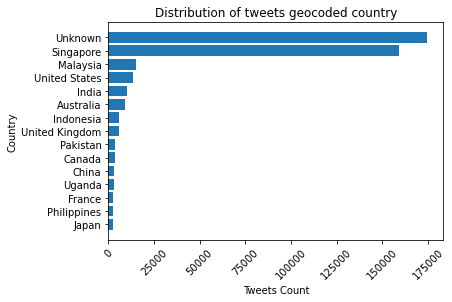

In [186]:
geocoded_tw_data = tweets_data['user_geo_coding']

count_geocoded_tw_data = col.Counter(geocoded_tw_data)
count_geocoded_tw_data = count_geocoded_tw_data.most_common()

# top X countries
TOP_X = 15
countries = [c[0].split('|')[0] for c in count_geocoded_tw_data[:TOP_X]]
counts = [c[1] for c in count_geocoded_tw_data[:TOP_X]]

plt.barh(countries[::-1], counts[::-1])
 
plt.ylabel("Country")
plt.xlabel("Tweets Count")
plt.xticks(rotation=45)
plt.title("Distribution of tweets geocoded country")
plt.show()

#### **Bug fixing**: Users whose location contains a `specific region in Singapore` (e.g., West Singpore, North-east regions) are erroneously coded as `Uganda`
TODO: Fix this during data collection

##### Looking for random examples with this error

In [107]:
wrong_geocoded_uganda_users  = list(tweets_data[tweets_data['user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].unique())
for _ in range(5):
    print("https://twitter.com/" + random.choice(wrong_geocoded_uganda_users))


https://twitter.com/syariqmarican
https://twitter.com/mvtin_nvlsor
https://twitter.com/thaddeusong92
https://twitter.com/robinnx7777
https://twitter.com/sgboyboyy


In [108]:
print(tweets_data[tweets_data['user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())
print(tweets_data[tweets_data['quoted_user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())
print(tweets_data[tweets_data['retweeted_user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())

641
22
78


#### 3.2.2. Replacing "Uganda|UG" with "Singapore|SG"

In [109]:
tweets_data['user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)
tweets_data['retweeted_user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)
tweets_data['quoted_user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)

#### 3.2.3. Remove the country code from the data (not required)

In [110]:
tweets_data['quoted_user_geo_coding'] = [c.split('|')[0] for c in tweets_data['quoted_user_geo_coding']]
tweets_data['retweeted_user_geo_coding'] = [c.split('|')[0] for c in tweets_data['retweeted_user_geo_coding']]
tweets_data['user_geo_coding'] = [c.split('|')[0] for c in tweets_data['user_geo_coding']]

##### Known Singaporeans 

In [111]:
#@muttons @cz_binance #MOEsg 

#### 3.2.4. Fixing **users with multiple geocoded countries**   

TODO: Fix this during data collection with the help of memoization

1. Geocoded countries is ``greater than 2`` 
    - Highly errorneos, set 'Unknown'
2. Geocoded countries count ``is 2`` 
    - If one of the geocodings is 'Unknown' then set the 'other' known location|
    -  If both the geocodings != 'Unknown' then set both to 'Unknown' (dubious case) 

In [112]:
# getting count of users' decoded locations 
# -- TODO what about quoted_user_screenname retweeted_user_screenname
users_geocode_country_count = tweets_data.groupby('user_screenname_x')['user_geo_coding'].nunique().reset_index(name='count')
# users_geocode_country_count[users_geocode_country_count['count'] > 1].sort_values(by='count', ascending=False)

In [113]:
# list of countries with geocoding > 2
users_geocode_country_count_gtr_2 = users_geocode_country_count[users_geocode_country_count['count'] > 2]['user_screenname_x'].unique()

# Setting location to 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'user_geo_coding'] = 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'retweeted_user_geo_coding'] = 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'retweeted_user_geo_coding'] = 'Unknown'

In [114]:
# TODO: Fix this elegantly
users_geocode_country_count_eq_2 = users_geocode_country_count[users_geocode_country_count['count'] == 2]['user_screenname_x']#.unique()
len(users_geocode_country_count_eq_2)

1437

##### Distribution of geo-coded tweets after corrections

In [115]:
geocoded_tw_data = tweets_data['user_geo_coding']

count_geocoded_tw_data = col.Counter(geocoded_tw_data)
count_geocoded_tw_data = count_geocoded_tw_data.most_common()

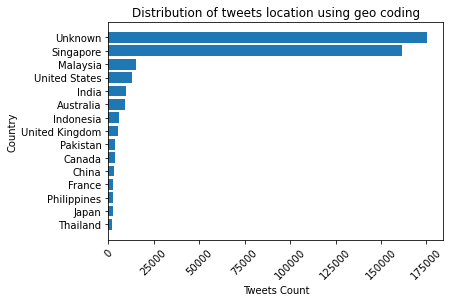

In [116]:
# top X countries
TOP_X = 15
countries = [c[0].split('|')[0] for c in count_geocoded_tw_data[:TOP_X]]
counts = [c[1] for c in count_geocoded_tw_data[:TOP_X]]

plt.barh(countries[::-1], counts[::-1])
 
plt.ylabel("Country")
plt.xlabel("Tweets Count")
plt.xticks(rotation=45)
plt.title("Distribution of tweets location using geo coding")
plt.show()

### 3.3. Filtering out non-Singapore accounts - reducing false positives and false negatives

In [117]:
sg_tweets = tweets_data[
                    # 1. geo coded as Singapore
                    (tweets_data['user_geo_coding'] == 'Singapore') | 
                    # 2. user location contains {sg, spore, singapore, singapura}
                    (tweets_data['user_location'].str.contains('sg|spore|singapore|singapura', regex=True, case=False)) |
                    # 3. user description contains {spore, singapore, singapura}
                    (tweets_data['user_desc'].str.contains('spore|singapore|singapura', regex=True, case=False)) |
                     # 4. Quoted tweets by Singaporean and 
                    ((tweets_data['quoted_user_geo_coding'] == 'Singapore') & (tweets_data['user_geo_coding'].isna())) |
                    ((tweets_data['retweeted_user_geo_coding'] == 'Singapore') & (tweets_data['user_geo_coding'].isna()))
            ]
sg_tweets.shape

(181423, 49)

In [ ]:
sg_tweets.columns

NameError: name 'sg_tweets' is not defined

### 3.4. Processing the tweets and quoted tweets

In [118]:
sg_tweets['tweet_text'] = [txt.replace('&amp;', '&') if isinstance(txt, str) else '' for txt in sg_tweets['tweet_text']]
sg_tweets['quoted_tweet_text'] = [ txt.replace('&amp;', '&') if isinstance(txt, str) else '' for txt in sg_tweets['quoted_tweet_text']]

##### Processing tweets and quoted tweets

In [120]:
from process_text_tm  import TwitterDataProcessing
pre = TwitterDataProcessing()

### 3.5. Predicting sentiment of tweets and quoted tweets

In [121]:
processed_tweets = [pre.clean_text(text) for text in sg_tweets['tweet_text']]
sg_tweets['processed_tweet_text'] = processed_tweets

processed_quoted_tweets = [pre.clean_text(text) if isinstance(text, str) == True else '' for text in sg_tweets['quoted_tweet_text']]
sg_tweets['processed_quoted_tweet_text'] = processed_quoted_tweets

##### Adding predicted sentiment for tweets and quoted tweets using off the shelf VADER

Predicting tweets and quoted tweets sentiments

In [123]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_sentiment(doc):
    score = analyzer.polarity_scores(doc)['compound']
    # As per vader's repo : https://github.com/cjhutto/vaderSentiment
    if score >= 0.05:
        sentiment = "positive"
    elif score <= -0.05:

        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment

In [125]:
tw_sentiment = [get_sentiment(text) for text in sg_tweets['processed_tweet_text']]
sg_tweets['tweet_sentiment'] = tw_sentiment

quoted_tw_sentiment = [get_sentiment(text) if text != '' else None for text in sg_tweets['processed_quoted_tweet_text']]
sg_tweets['quoted_tweet_sentiment'] = quoted_tw_sentiment

In [148]:
# df_hashtags_data = pd.DataFrame(data=hashtags_data)
pd.DataFrame.to_csv(df_sentiments, "data/output/basics/sentiments.csv")

In [128]:
print("---- Duration ---")
print("From {} to {} \n".format(sg_tweets['tweet_date'].min(), sg_tweets['tweet_date'].max()))

print("---- Tweets count---")
print(sg_tweets.shape[0], '\n')

print("---- Attributes---")
sg_tweets.columns

---- Duration ---
From 2021-08-04 to 2021-09-24 

---- Tweets count---
181423 

---- Attributes---


Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

#### Saving the final data with curated sg-tweets for analysis

In [129]:
sg_tweets = sg_tweets.loc[:, ~sg_tweets.columns.str.contains('^Unnamed')]
pd.DataFrame.to_csv(sg_tweets, BASE_PATH + "sg.csv")

## 4. Exploratory data analysis of Singapore geo-coded tweets

### 4.1. Basics

In [163]:
sg_tweets.shape

(181423, 53)

In [190]:
total_tweets = len(sg_tweets)
total_tweets

181423

#### Duration

In [130]:
MAX_DATE = sg_tweets['tweet_date'].max()
MIN_DATE = sg_tweets['tweet_date'].min()
MAX_DATE, MIN_DATE

('2021-09-24', '2021-08-04')

#### Average tweets per day

In [164]:
daily_tweets  = sg_tweets.groupby('tweet_date')['tweet_id'].count().reset_index(name='count')
avg_tweets = sum(daily_tweets['count'][:-1])/ len(daily_tweets['count'][:-1])
avg_tweets

3554.901960784314

##### Distribution of **tweets** sentiments

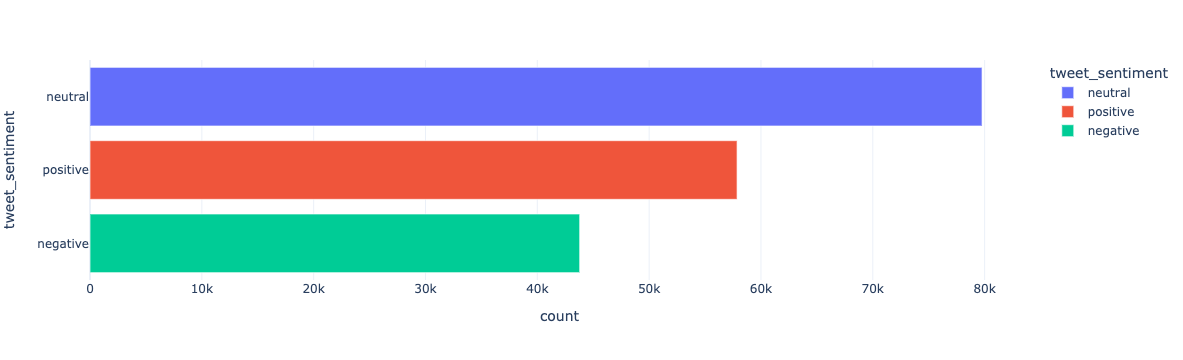

In [264]:
df_sentiments = sg_tweets.value_counts(subset=['tweet_sentiment']).reset_index(name='count').sort_values(['count'], ascending=False)

fig = px.bar(df_sentiments, x="count", y="tweet_sentiment", orientation='h', template="plotly_white", color="tweet_sentiment")
fig.show()

##### Distribution of **quoted tweets** sentiments

In [197]:
df_quoted_sentiments = sg_tweets.value_counts(subset=['quoted_tweet_sentiment']).reset_index(name='count').sort_values(['count'], ascending=False)

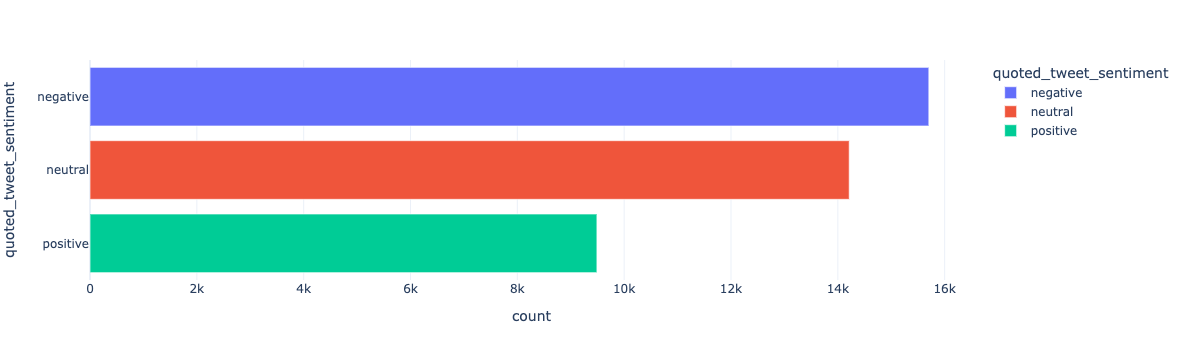

In [254]:
fig = px.bar(df_quoted_sentiments, x="count", y="quoted_tweet_sentiment", orientation='h', template="plotly_white", color="quoted_tweet_sentiment")
fig.show()

##### Reaction on the quoted tweets through sentiment analysis

In [265]:
quoted_tweets_with_sentiment = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & (sg_tweets['quoted_tweet_sentiment'].notna())]

In [266]:
sentiments = ['positive', 'negative', 'neutral']
sentiments_comb = it.product(sentiments, sentiments)
sentiments_comb = list(sentiments_comb)
sentiments_comb

[('positive', 'positive'),
 ('positive', 'negative'),
 ('positive', 'neutral'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('negative', 'neutral'),
 ('neutral', 'positive'),
 ('neutral', 'negative'),
 ('neutral', 'neutral')]

In [267]:
for s1, s2 in sentiments_comb:
    sc.append('{}_{}'.format(s1, s2))
    print("Tweet: {} | Quoted: {} - {}".format(s1, s2, len(sg_tweets[(sg_tweets['tweet_sentiment'] == s1) &  (sg_tweets['quoted_tweet_sentiment'] == s2)])))

Tweet: positive | Quoted: positive - 3187
Tweet: positive | Quoted: negative - 2444
Tweet: positive | Quoted: neutral - 3341
Tweet: negative | Quoted: positive - 1654
Tweet: negative | Quoted: negative - 4933
Tweet: negative | Quoted: neutral - 2863
Tweet: neutral | Quoted: positive - 4649
Tweet: neutral | Quoted: negative - 8327
Tweet: neutral | Quoted: neutral - 8009


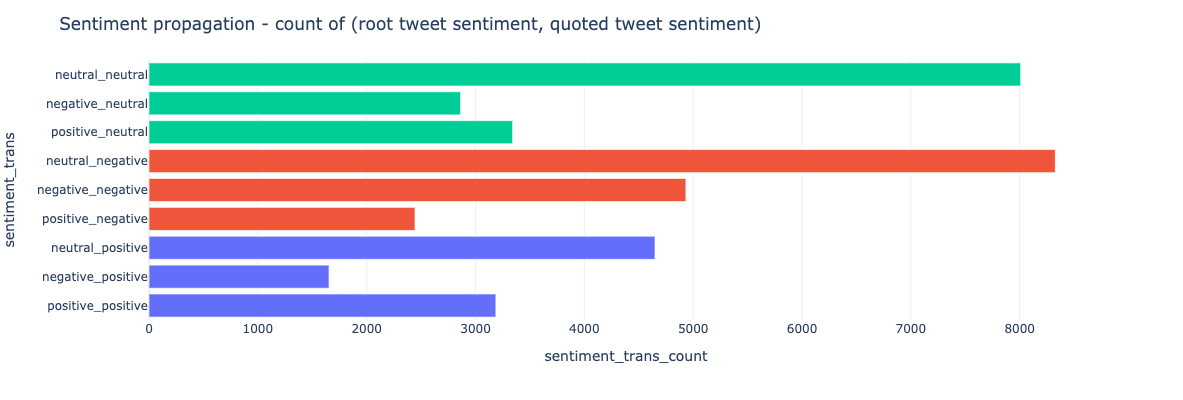

In [268]:
sc = []
sc_count = []
colors = []
for s1, s2 in sentiments_comb:
    sc.append('{}_{}'.format(s1, s2))
    if s2 == 'negative': colors.append('red') 
    elif s2 == 'neutral': colors.append('#FFFF00')
    else: colors.append('green')
    sc_count.append( len(sg_tweets[(sg_tweets['tweet_sentiment'] == s1) &  (sg_tweets['quoted_tweet_sentiment'] == s2)]))
    
sentiment_count = {
    'sentiment_trans': sc,
    'sentiment_trans_count': sc_count
}
sentiment_count

fig = px.bar(sentiment_count, x="sentiment_trans_count", y="sentiment_trans", template='plotly_white', color=colors, 
             height=400)
fig.update_layout(showlegend=False, title="Sentiment propagation - count of (root tweet sentiment, quoted tweet sentiment)")
fig.show()

In [269]:
FROM_SENTIMENT = 'negative'
TO_SENTIMENT = 'positive'

sg_tweets[(sg_tweets["tweet_sentiment"] == FROM_SENTIMENT) & \
          (sg_tweets["quoted_tweet_sentiment"] == TO_SENTIMENT)][['tweet_text', 'quoted_tweet_text']]

tweet_text  \
29      RT @h3yril: shopping malls are so crowded and ...   
113     RT @h3yril: shopping malls are so crowded and ...   
303     #WhatIsHappeningInMyanmar\n#MyanmarCovidSOS \n...   
306     #WhatIsHappeningInMyanmar\n#MyanmarCovidSOS \n...   
315     #WhatIsHappeningInMyanmar\n#MyanmarCovidSOS \n...   
...                                                   ...   
427908  RT @AAhronheim: Seriously??? Are you honestly ...   
428290  i can think of several other reasons why being...   
428432  RT @KirralieS: The slumber is very deep. I dou...   
429173  RT @indulekshmi16: The fact that they weren‚Äôt ...   
429637  Can somebody think how to make MALAYSIA strong...   

                                        quoted_tweet_text  
29      URA: Safe distancing officers can enter & insp...  
113     URA: Safe distancing officers can enter & insp...  
303     ‚ÄúIf the elected civilian government had admini...  
306     ‚ÄúIf the elected civilian government had admini...  
315     ‚ÄúIf the elected civilian government had admini...  
...                                                   ...  
427908  When you yearn for freedom, sometimes a spoon ...  
428290  WATCH:\nUS military walk-outs occurred after B...  
428432  What is even going on in Australia?\n\nParliam...  
429173  Up to 500 vaccinated migrant workers a week ca...  
429637  Bill to limit propagation of non-Muslim faiths...  

[1654 rows x 2 columns]

### 4.2. Analysing Singapore users 

In [131]:
print( "# of unique Singapore users:", sg_tweets['user_id_x'].nunique())
print( "# of verified Singapore users:", sg_tweets[sg_tweets['user_verified'] == True]['user_id_x'].nunique())

# of unique Singapore users: 25922
# of verified Singapore users: 374


In [207]:
# Saving data for the dashboard
basic_data = {
    'total_tweets': total_tweets,
    'min_date': MIN_DATE,
    'max_date': MAX_DATE,
    'avg_tweets': int(avg_tweets)

}

with open('data/output/basics/basic.json', 'w') as fp:
    json.dump(basic_data, fp)

#### Users with high number of followers

In [529]:
MIN_FOLLOWERS = 10000
sg_tweets['user_followers_count'] = sg_tweets['user_followers_count'].astype(int)
sg_users_high_followers = sg_tweets[sg_tweets['user_followers_count'] >= MIN_FOLLOWERS].groupby('user_screenname_x') \
[['user_desc', 'user_verified', 'user_followers_count']].nth(0).sort_values(by='user_followers_count', ascending=False)
sg_users_high_followers.head(10)

user_desc  \
user_screenname_x                                                      
straits_times      Stay in the know with the latest news from Sin...   
ChannelNewsAsia    The official space of CNA - the source of brea...   
leehsienloong      Prime Minister of Singapore and leader of the ...   
TODAYonline        Get the latest local and international news fr...   
zaobaosg           http://zaobao.sg ÊòØÊñ∞Âä†Âù°Êä•‰∏öÊéßËÇ°Â±û‰∏ãÁöÑÁΩëÁ´ô„ÄÇ‰ª•Á¨¨‰∏âÂè™ÁúºÁúãÂ§ß‰∏≠ÂçéÔºåÂÆ¢ËßÇÊñ∞ÈóªÂíå...   
SoSingaporean      Follow to discover everything so unique and #s...   
NEAsg              Also on Facebook https://t.co/xNg9BTncsL, Inst...   
mrbrown            mrbrown aka LEE Kin Mun, Blogfather of Singapo...   
charlesyeo         If you love something use your brain; love som...   
duongcam0909               ùêìùê°ùêû ùê¶ùê®ùê´ùêû ùòÜùóºùòÇ ùê†ùê¢ùêØùêû, ùê≠ùê°ùêû ùê¶ùê®ùê´ùêû ùòÜùóºùòÇ ùê´ùêûùêúùêûùê¢ùêØùêû .   

                  user_verified  user_followers_count  
user_screenname_x                                      
straits_times              True               1086547  
ChannelNewsAsia            True               1053198  
leehsienloong              True                798436  
TODAYonline                True                692039  
zaobaosg                  False                518588  
SoSingaporean             False                461939  
NEAsg                      True                440894  
mrbrown                    True                400728  
charlesyeo                False                349669  
duongcam0909              False                334940

In [ ]:
print("Count of users >= {} followers". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == True])))
print("Count of verified user with {} followers is {}". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == True])))
print("Count of unverified user with {} followers is {}". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == False])))

### 4.3. Potentially sensitive tweets (PST) with links - marked by twitter

In [221]:
sg_tweets_pst = sg_tweets[sg_tweets['tweet_possibly_sensitive'] == True]

print("Total possibily sensitive tweets {}".format(len(sg_tweets_pst)))
print("% possibily sensitive tweets {}".format(len(sg_tweets_pst)/len(sg_tweets)*100))

Total possibily sensitive tweets 9212
% possibily sensitive tweets 5.077636242372797


In [222]:
PST_THRESHOLD = 400 # random high threshold to visualize unusal number of PSTs
c_sg_tweets_pst = sg_tweets_pst.value_counts(subset=['tweet_date']).reset_index(name='count') \
                                                .sort_values(['tweet_date'], ascending=False)

print("Average number of Potentially sensitive tweets: ", sum(c_sg_tweets_pst['count'])/len(c_sg_tweets_pst))

Average number of Potentially sensitive tweets:  204.7111111111111


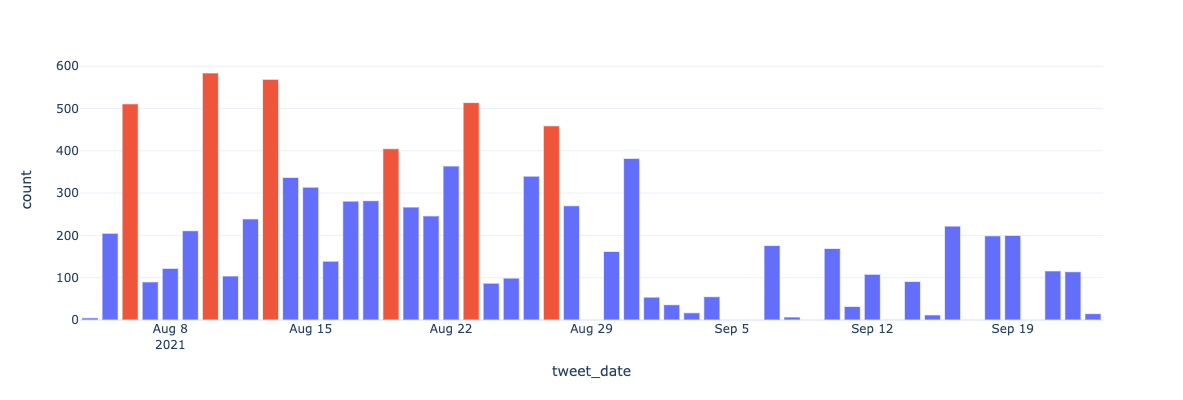

In [223]:
colors = ["red" if cc > PST_THRESHOLD else "green" for cc in c_sg_tweets_pst['count']]
fig = px.bar(c_sg_tweets_pst, x="tweet_date", y="count", template='plotly_white', color=colors,
             height = PST_THRESHOLD)
fig.update_layout(showlegend=False)
fig.show()

##### Dates with high PSTs

In [227]:
tweet_date_high_pst = c_sg_tweets_pst[c_sg_tweets_pst['count'] > PST_THRESHOLD]['tweet_date']
list(tweet_date_high_pst)

['2021-08-27',
 '2021-08-23',
 '2021-08-19',
 '2021-08-13',
 '2021-08-10',
 '2021-08-06']

### 4.4.  Popular hashtags

In [229]:
sg_tweets_hashtags = sg_tweets[sg_tweets['entity_hashtags'].notna()]['entity_hashtags']

print("Count of tweets with hashtags {}".format(len(sg_tweets_hashtags)))
print("% of tweets with hashtags {}".format(len(sg_tweets_hashtags)/len(sg_tweets)*100))

Count of tweets with hashtags 43083
% of tweets with hashtags 23.747264679781505


In [230]:
hashtags = []

for h in sg_tweets_hashtags:
    h_list = [hh for hh in h.split('|') if hh not in ['Singapore', 'singapore', 'sg']]
    hashtags.extend(h_list)

print("Total hashtags:", len(hashtags))
print("Total unique hashtags:", len(set(hashtags)))

Total hashtags: 89848
Total unique hashtags: 12737


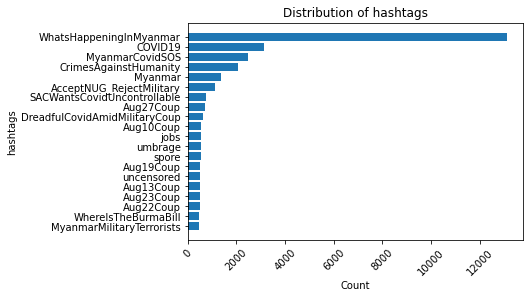

In [144]:
count_hashtags = col.Counter(hashtags).most_common()

TOP_X = 20
hashtags = [c[0] for c in count_hashtags[:TOP_X]]
counts = [c[1] for c in count_hashtags[:TOP_X]]

# count_hashtags
plt.barh(hashtags[::-1], counts[::-1])
 
plt.ylabel("hashtags")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of hashtags")
plt.show()

In [155]:
# Saving data for the dashboard
hashtags_data = {
    "counts": counts[::-1],
    "hashtag": hashtags[::-1]
}

df_hashtags_data = pd.DataFrame(data=hashtags_data)
pd.DataFrame.to_csv(df_hashtags_data, "data/output/basics/hashtags.csv")

### 4.5. Popular mentions

In [232]:
sg_tweets_mentions = sg_tweets[sg_tweets['entity_mentions'].notna()]['entity_mentions']

print("Count of tweets with mentions {}".format(len(sg_tweets_mentions)))
print("% tweets with mentions {}".format(len(sg_tweets_mentions)/len(sg_tweets)*100))

Count of tweets with mentions 91955
% tweets with mentions 50.68541474895686


In [233]:
mentions = []

for m in sg_tweets_mentions:
    m_list = [mm for mm in m.split('|')]
    mentions.extend(m_list)

print("Total mentions:", len(mentions))
print("Total unique mentions:", len(set(mentions)))

Total mentions: 116606
Total unique mentions: 37576


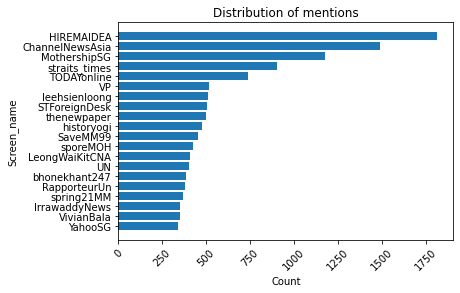

In [234]:
count_mentions = col.Counter(mentions).most_common()

TOP_X = 20
mentions = [c[0] for c in count_mentions[:TOP_X]]
counts = [c[1] for c in count_mentions[:TOP_X]]

# count_mentions
plt.barh(mentions[::-1], counts[::-1])
 
plt.ylabel("Screen_name")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of mentions")
plt.show()

In [235]:
# Saving data for the dashboard
mentions_data = {
    "counts": counts[::-1],
    "mention": mentions[::-1]
}

df_mentions_data = pd.DataFrame(data=mentions_data)
pd.DataFrame.to_csv(df_mentions_data, "data/output/basics/mentions.csv")
df_mentions_data

counts          mention
0      338          YahooSG
1      349       VivianBala
2      352    IrrawaddyNews
3      370       spring21MM
4      377     RapporteurUn
5      387    bhonekhant247
6      401               UN
7      407   LeongWaiKitCNA
8      423         sporeMOH
9      456         SaveMM99
10     478       historyogi
11     502      thenewpaper
12     503    STForeignDesk
13     509    leehsienloong
14     516               VP
15     740      TODAYonline
16     903    straits_times
17    1177     MothershipSG
18    1491  ChannelNewsAsia
19    1816       HIREMAIDEA

### 4.6. Regional analysis 

**Factual**: Population by region:
- **Central Region**	922,580

- **East Region** 685,890

- **North Region** 582,330 

- **North-East Region** 930,910 

- **West Region** 922,540 

In [249]:
# tw_user_location = data[data['user_location'].str.contains('sg|singapore|sin',
#                                                                   na = False, case=False, regex=True)]
# tw_user_location = list(tw_user_location['user_location'])
# print(len(tw_user_location))
# set(tw_user_location)
tw_user_location = list(sg_tweets[sg_tweets['user_geo_tagging'].notna()]['user_geo_tagging'])
print("Tweets from Central: ", sum('Central' in s for s in tw_user_location))
print("Tweets from West: ", sum('West' in s for s in tw_user_location))
print("Tweets from East: ", sum('East ' in s for s in tw_user_location))
print("Tweets from North-East: ", sum('North-East' in s for s in tw_user_location))
print("Tweets from North: ", sum('North ' in s for s in tw_user_location))
print("-"*10)
print("Tweets from Central: ", sum('Central' in s for s in tw_user_location)/len(tw_user_location)*100)
print("Tweets from West: ", sum('West' in s for s in tw_user_location)/len(tw_user_location)*100)
print("Tweets from North-East: ", sum('North-East' in s for s in tw_user_location)/len(tw_user_location)*100)
print("Tweets from North: ", sum('North ' in s for s in tw_user_location)/len(tw_user_location)*100)
print("Tweets from East: ", sum('East ' in s for s in tw_user_location)/len(tw_user_location)*100)

Tweets from Central:  757
Tweets from West:  298
Tweets from East:  571
Tweets from North-East:  371
Tweets from North:  133
----------
Tweets from Central:  13.393489030431704
Tweets from West:  5.27246992215145
Tweets from North-East:  6.5640481245576785
Tweets from North:  2.3531493276716207
Tweets from East:  10.102618542108988


### 4.7. Others

Tracking:
    Popular SG accounts not geocoded as Sngapore: @muttons @cz_binance MOEsg 
    Adult accounts: 

#### Fake news

In [443]:
fake_news_sources = []
with open("fk.txt", 'r') as f:
    for line in f:
        fake_news_sources.append(line.strip('\n'))

fake_news_sources_reg = '|'.join(fake_news_sources)

In [447]:
len(fake_news_sources)

999

In [451]:
fk = sg_tweets[sg_tweets['entity_link_url'].str.lower().str.contains(fake_news_sources_reg, na=False, regex=True, case=False)]

#### Images shared on twitter 

In [245]:
imgs_sg_tweets = sg_tweets[(sg_tweets['entity_image_url'].notna())]
imgs_sg_tweets['entity_image_url']

9         https://pbs.twimg.com/media/E71g09BVkAQ9wGv.jpg
21        https://pbs.twimg.com/media/E8FPGNyVIAAsIzr.png
27        https://pbs.twimg.com/media/E8CUEqGXsAAwEZ6.jpg
57        https://pbs.twimg.com/media/E8FExRBUUAYg2Pn.jpg
65        https://pbs.twimg.com/media/E8BVOYcVgAIH4_j.png
                               ...                       
429548    https://pbs.twimg.com/media/E-9VwiGUcAA-lDW.jpg
429713    https://pbs.twimg.com/media/E-6cVEUVIAA-tKw.jpg
429748    https://pbs.twimg.com/media/E-7oiBSVUAMZvgH.jpg
429777    https://pbs.twimg.com/media/E-90ZjPXEC8zY81.jpg
429825    https://pbs.twimg.com/media/E-lvmKhXIAcsDYw.jpg
Name: entity_image_url, Length: 13166, dtype: object

#### Listing tweets with random hate words

In [238]:
hate_sg_tweets = sg_tweets[(sg_tweets['tweet_text'].str.contains('racism|racist|xeno', case=False, regex=True))]
hate_sg_tweets.shape

(268, 53)

In [242]:
list(hate_sg_tweets['tweet_text'])[:10]

['RT @fuhduhduhh: imagine seeing chinese singaporeans being racist and thinking "how far singapore has fallen without lky\'s authority"',
 'No but wait what do you mean racism doesn‚Äôt exist in Singapore? I don‚Äôt care if you haven‚Äôt faced it bro I‚Äôve known‚Ä¶ https://t.co/Qgv6JpNCcX',
 '@PeterFl13201217 @Inseer_ @Dominic2306 Do you think Singapore is not xenophobic. \n\nSingapore is far more xenophobic‚Ä¶ https://t.co/P5ABrH4GiE',
 'Tik Tok series: Racism in Singapore\nEP 3: What is your view on xenophobia in Singapore?\n\nWatch here: https://t.co/M49Ui7Ns2A',
 "Well won't this be very interesting. Covid safety & health vs the 'racism' debate. Quite the conundrum and a true t‚Ä¶ https://t.co/GXHWi74aBz",
 'RT @sara_sailesh: Racism in Singapore against Indians are so bad that I worry for my children in the future . \n\nSuch a small country but so‚Ä¶',
 '@BahrSinan @Xeno_Imperial @MegaManMain @DudespostingWs Probably holiday... there was soccer events in Singapore but‚Ä¶ https://t

#### Local news Singapore reporters 

In [ ]:
sg_tweets[sg_tweets['user_screenname_x'].isin(['stompsingapore'])]['tweet_text']